In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

1. usually in *anomaly-detection systems*, like credit-card fraud detection.
2. harmful to be present in the dataset
3. in network-traffic, tracking of hacking-activity can employ anomaly-detection methods which will basically search for outliers
4. in the field of medicine, for detecting whether a patient is suffering from a rare disease, positive samples will certainly be few in number and mostly act as outliers
5. depending upon the problem statement, outliers can either <font color="green">impart special knowledge about the problem</font> , or <font color="red">can hamper the process of model-learning altogether </font>
6. for instance
    1. we can rule out outliers in the case of the titanic dataset problem, since there is no objective way to prove that survival was actually dependent upon any of the given features in a one-to-one fashion
    2. but in case of time-series data of sales, the spikes observed in the sale-value act as outliers, but still it is advisable to keep them because it might be interesting to explore as to why only on those particular time-periods was the spike observed, or rather why on the remaining time-period did the spikes not appear
7. some ML models are <font color="green">not sensitive</font> to outliers
    1. naive-bayes classifiers/regressor
    2. SVM
    3. decision-trees
    4. ensemble techniques like randomforest, xgboost, GB
    5. kNN
8. some ML models are <font color="red">sensitive</font> to outliers
    1. linear regression
    2. logistic regression
    3. K-Means(clustering based on outliers as well) 
    4. hierarchial clustering
    5. PCA
    6. neural networks

In [2]:
df_train = pd.read_csv("../input/titanic/train.csv")
df_test = pd.read_csv("../input/titanic/test.csv")

In [3]:
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

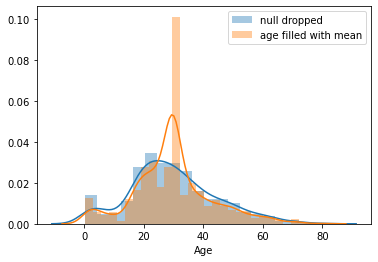

In [10]:
import matplotlib.pyplot as plt
import seaborn as sb
sb.distplot(df_train['Age'].dropna(), label='null dropped')
sb.distplot(df_train['Age'].fillna(df_train['Age'].mean()), label='age filled with mean')
plt.legend()
plt.show()

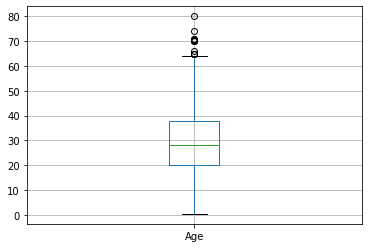

In [15]:
df_train.boxplot(column="Age")
plt.show()

For a gaussian distribution, values outside of $\mu-3\sigma$ and $\mu+3\sigma$ are generally considered as outliers,\
Since on dropping null values, the "Age" column has a gaussian-like distribution, we can assume values outside of $\mu-3\sigma$ and $\mu+3\sigma$ as outliers w.r.t. the feature Age.

In [17]:
meanAge, sigma = df_train['Age'].dropna().mean(), df_train['Age'].dropna().std()
print("Lower boundary is: ", meanAge-3*sigma, " and upper boundary is: ", meanAge+3*sigma)

Lower boundary is:  -13.88037434994331  and upper boundary is:  73.27860964406095


hence values > 73.28 can be easily brushed off as outliers and if required can be removed, the content coming after this is basically to handle skewed, non-Gaussian distributed data

In [18]:
# interquantile range
IQR = df_train['Age'].quantile(0.75) - df_train['Age'].quantile(0.25)
print(IQR)

17.875


In [19]:
# lower bridge and upper bridge
lB, uB = df_train['Age'].quantile(0.25) - 1.5*IQR, df_train['Age'].quantile(0.75) + 1.5*IQR
print("lower bridge is:", lB, " and the upper bridge is:", uB)

lower bridge is: -6.6875  and the upper bridge is: 64.8125


In [20]:
# extreme boundaries, also called extreme outliers, can be identifies by this
lE, uE = df_train['Age'].quantile(0.25) - 3*IQR, df_train['Age'].quantile(0.75) + 3*IQR
print("lower extreme is:", lE, " and the upper extreme is:", uE)

lower extreme is: -33.5  and the upper extreme is: 91.625


Lets consider another feature, **Fare**

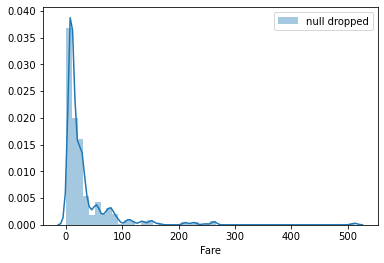

In [22]:
sb.distplot(df_train['Fare'].dropna(), label='null dropped')
# sb.distplot(df_train['Fare'].fillna(df_train['Fare'].mean()), label='fare filled with mean')
plt.legend()
plt.show()

Left-skewed distribution

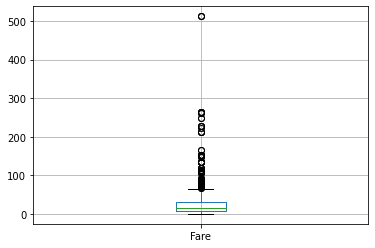

In [24]:
df_train.boxplot(column="Fare")
plt.show()

In [25]:
df_train['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

Observe the difference between max value and the 75% value, this is a clear indication that a large number of outliers are present

In [26]:
IQR = df_train['Fare'].quantile(0.75) -df_train['Fare'].quantile(0.25)

# extreme boundaries, also called extreme outliers, can be identifies by this
lE, uE = df_train['Fare'].quantile(0.25) - 3*IQR, df_train['Fare'].quantile(0.75) + 3*IQR
print("lower extreme is:", lE, " and the upper extreme is:", uE)

lower extreme is: -61.358399999999996  and the upper extreme is: 100.2688


In [32]:
print(df_train[df_train['Fare'] > uE]['Fare'].count(), "is the number of samples that can be easily brushed off as outliers")
print("Indices of these outliers are: ", df_train[df_train['Fare'] > uE].index)

53 is the number of samples that can be easily brushed off as outliers
Indices of these outliers are:  Int64Index([ 27,  31,  88, 118, 195, 215, 258, 268, 269, 297, 299, 305, 306,
            307, 311, 318, 319, 325, 332, 334, 337, 341, 373, 377, 380, 390,
            393, 435, 438, 498, 505, 527, 537, 544, 550, 557, 581, 609, 659,
            660, 679, 689, 698, 700, 708, 716, 730, 737, 742, 763, 779, 802,
            856],
           dtype='int64')


Replacing outlier values with the extreme boundary value/upper bridge value/upper boundary value can also employed

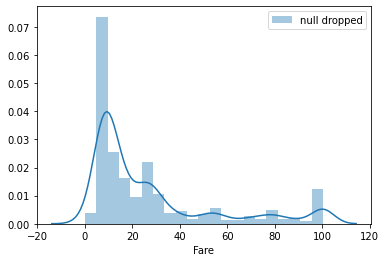

In [33]:
IQR_age = df_train['Age'].quantile(0.75) - df_train['Age'].quantile(0.25)
lE_age, uE_age = df_train['Age'].quantile(0.25) - 3*IQR_age, df_train['Age'].quantile(0.75) + 3*IQR_age
df_train.loc[df_train['Age'] > uE_age] = uE_age
df_train.loc[df_train['Age'] < lE_age] = lE_age

IQR_fare = df_train['Fare'].quantile(0.75) - df_train['Fare'].quantile(0.25)
lE_fare, uE_fare = df_train['Fare'].quantile(0.25) - 3*IQR_fare, df_train['Fare'].quantile(0.75) + 3*IQR_fare
df_train.loc[df_train['Fare'] > uE_fare] = uE_fare
df_train.loc[df_train['Fare'] < lE_fare] = lE_fare

sb.distplot(df_train['Fare'].dropna(), label='null dropped')
plt.legend()
plt.show()

In [34]:
df_train['Fare'].describe()

count    891.000000
mean      27.043158
std       27.339465
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      100.268800
Name: Fare, dtype: float64

In [39]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df_train[['Age', 'Fare']].fillna(0), df_train['Survived'], test_size=0.3, random_state=42)

from sklearn.linear_model import LogisticRegression as LR
lr = LR()

lr.fit(x_train, y_train)

ValueError: Unknown label type: 'continuous'